# BLG641E- Medical Image Computing
Kadriye Tuba Turkcan Karaca

## Age regression from brain MRI

Predicting the age from a brain MRI scan is believed to have diagnostic value in the context of a number of pathologies that cause structural changes and damage to the brain. Assuming an accurate predictor of brain age can be trained based on a set of healthy subjects, the idea is then to compare the predicted age obtained on a new patient scan with the real age of that patient. Discrepancy between predicted and real age might indicate the presence of pathology and abnormal changes to the brain.

The objective for the project is to implement volume-based Regression using brain structure segmentation. Data from 652 subjects is provided.


In [1]:
# Use full browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Getting started

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the population of 652 subjects. Let's start by loading the meta data, that is the data containing information about the subject IDs, their age, and gender.

In [3]:
# Read the meta data using pandas
import pandas as pd

data_dir = 'project-data/'



In [4]:
import os
print(os.listdir(data_dir))

['new_images', 'greymatter', 'newmsub-CC110033_T1w_rigid_to_mni.nii.gz', 'meta', 'images', 'masks', '.ipynb_checkpoints', 'msub-CC110033_T1w_rigid_to_mni.nii.gznew.nii']


In [5]:
meta_data = pd.read_csv(data_dir + 'meta/clean_participant_data.csv')
meta_data.head() # show the first five data entries

ID  age  gender_code gender_text
0  CC110033   24            1        MALE
1  CC110037   18            1        MALE
2  CC110045   24            2      FEMALE
3  CC110056   22            2      FEMALE
4  CC110062   20            1        MALE

Let's have a look the the population statistics.

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


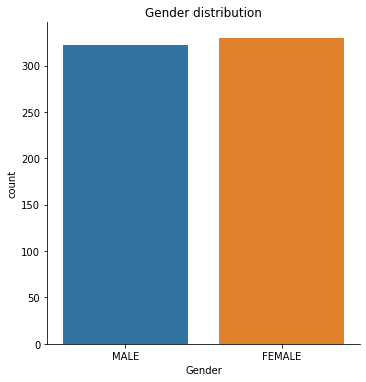

In [7]:
sns.factorplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

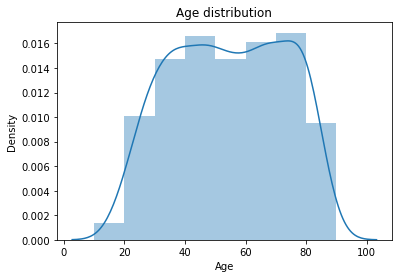

In [8]:
sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

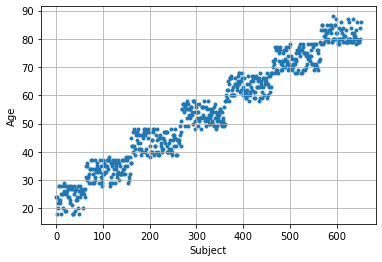

In [9]:
plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up the image viewer

In [10]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline

In [11]:
# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high


In [12]:
def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()

In [13]:
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

In [14]:
import glob

# Subject with index 0
ID = meta_data['ID'][0]
age = meta_data['age'][0]


In [15]:
# Data folders
image_dir = data_dir + 'images/'
image_filenames = glob.glob(image_dir + '*.nii.gz')

mask_dir = data_dir + 'masks/'
mask_filenames = glob.glob(mask_dir + '*.nii.gz')

greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')


In [16]:
#print(os.listdir(image_dir))
#print(image_filenames)
print(len(image_filenames))

652


In [17]:
image_file = [f for f in image_filenames if ID in f]
print(image_file)

['project-data/images/msub-CC110033_T1w_rigid_to_mni.nii.gz']


In [18]:
image_filename = [f for f in image_filenames if ID in f][0]
img = sitk.ReadImage(image_filename)

mask_filename = [f for f in mask_filenames if ID in f][0]
msk = sitk.ReadImage(mask_filename)
#print(msk)

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


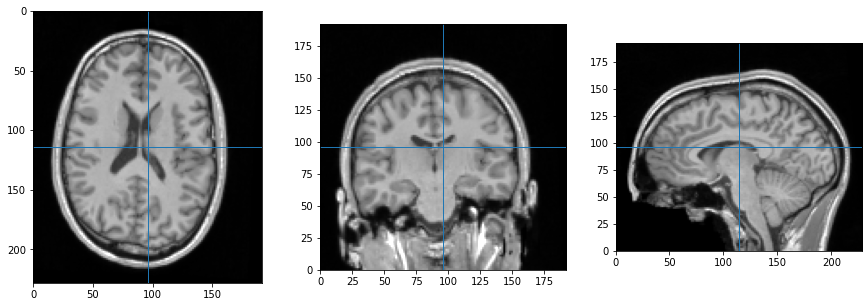

Brain mask (used in part A)


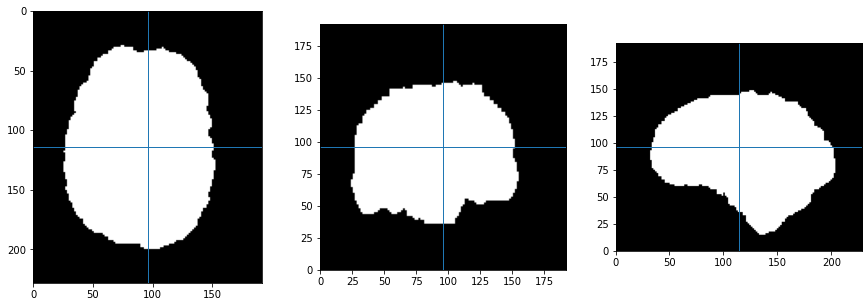

Spatially normalised grey matter maps (used in part B)


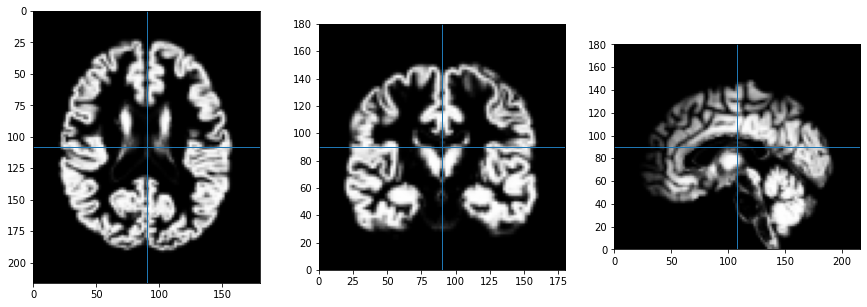

In [19]:
# Subject with index 0
print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B)')
display_image(gm)

## Volume-based regression using brain structure segmentation

This approach aims to regress the age of a subject from the volumes of brain tissues, including grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume might decrease. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a three-class brain tissue segmentation needs to be implemented and applied to the provided 652 brain scans. Brain masks are provided which have been generated with a state-of-the-art brain extraction tool from the FSL toolkit.

Different regression techniques is explored, and the best set of features for this task is investigated.

### Brain tissue segmentation

A brain tissue segmentation method which provides segmentations of GM, WM, and CSF is implemented.  This method is applied to all 652 MR images, and the three tissue volumes is calculated for each subject.

In [20]:
# Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
# set to outside_value. The sphere's have higher intensity values than the background, so they are outside.

#inside_value = 0
#outside_value = 255
#number_of_histogram_bins = 100
#mask_output = True

#labeled_result = sitk.OtsuThreshold(img,msk,inside_value, outside_value, 255)

In [22]:
#print(img)

In [21]:
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)
msk_array = msk_array.astype(bool)
print(len(img_array))
print(img_array.shape)
print(len(msk_array))
print(msk_array.shape)
print(msk_array.dtype)

128
(128, 152, 128)
128
(128, 152, 128)
bool


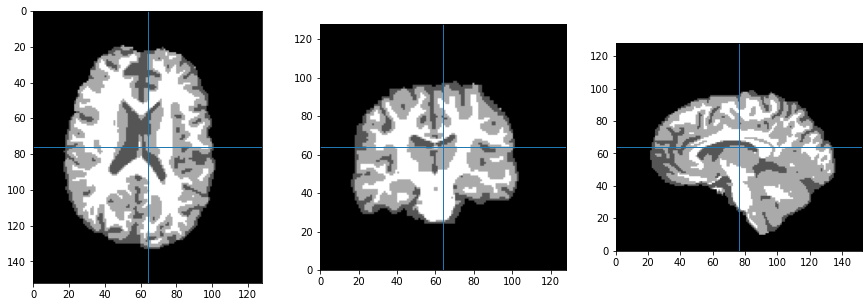

In [22]:
from nipy.algorithms.segmentation import BrainT1Segmentation
# Convert SimpleITK image to NumPy array
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)
msk_array = msk_array.astype(bool)
S = BrainT1Segmentation(img_array,
                        mask=msk_array,       
                        model='5k',
                        niters=int(50),  # number of iterations
                        beta=float(0.5), # Markov regularization parameter
                        ngb_size=int(6)) # neighborhood size of MRF
#print(S.label)
img_S = sitk.GetImageFromArray(S.label)
display_image(img_S)

project-data/images/msub-CC110033_T1w_rigid_to_mni.nii.gz


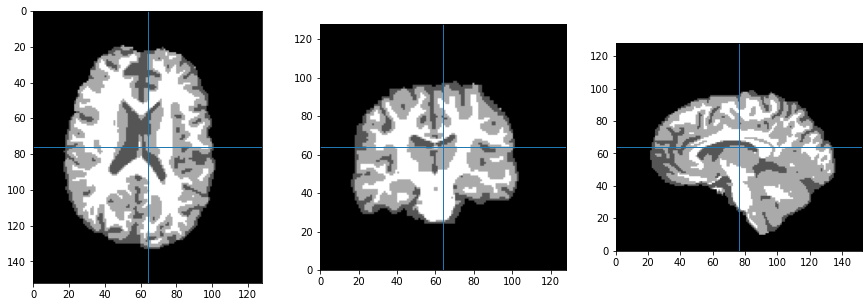

In [23]:
#name = img.split('/')[-1] + '.nii'
print(image_filename)
name = 'new' + image_filename.split('/')[-1]
save_dir = data_dir + 'new_images/'
save_path = os.path.join(save_dir,name)   #   get the save path
sitk.WriteImage(img_S,save_path) 
img_new = sitk.ReadImage(save_dir + name)
display_image(img_new)

In [24]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(img_S)

In [25]:
shape_labels = shape_stats.GetLabels()
print(shape_labels)
shape_volumes = [shape_stats.GetPhysicalSize(label) for label in shape_labels] 

(1, 2, 3)


In [28]:
print(shape_volumes)

[101765.0, 210876.0, 107543.0]


In [26]:
for i in range(5):
    # Subject with index 0
    ID = meta_data['ID'][i]
    image_filename = [f for f in image_filenames if ID in f][0]
    img = sitk.ReadImage(image_filename)
    mask_filename = [f for f in mask_filenames if ID in f][0]
    msk = sitk.ReadImage(mask_filename)
    img_array = sitk.GetArrayFromImage(img)
    msk_array = sitk.GetArrayFromImage(msk)
    msk_array = msk_array.astype(bool)
    S = BrainT1Segmentation(img_array,
                        mask=msk_array,       
                        model='5k',
                        niters=int(50),  # number of iterations
                        beta=float(0.5), # Markov regularization parameter
                        ngb_size=int(6)) # neighborhood size of MRF
    img_S = sitk.GetImageFromArray(S.label)
    name = 'new' + image_filename.split('/')[-1]
    save_dir = data_dir + 'new_images/'
    save_path = os.path.join(save_dir,name)   #   get the save path
    sitk.WriteImage(img_S,save_path) 
    

In [27]:
# Data folders
new_image_dir = data_dir + 'new_images/'
new_image_filenames = glob.glob(new_image_dir + '*.nii.gz')
print(new_image_filenames[0])
new_name = new_image_filenames[0].split('/')[-1]
print(new_name)

project-data/new_images/newmsub-CC221585_T1w_rigid_to_mni.nii.gz
newmsub-CC221585_T1w_rigid_to_mni.nii.gz


newmsub-CC221585_T1w_rigid_to_mni.nii.gz


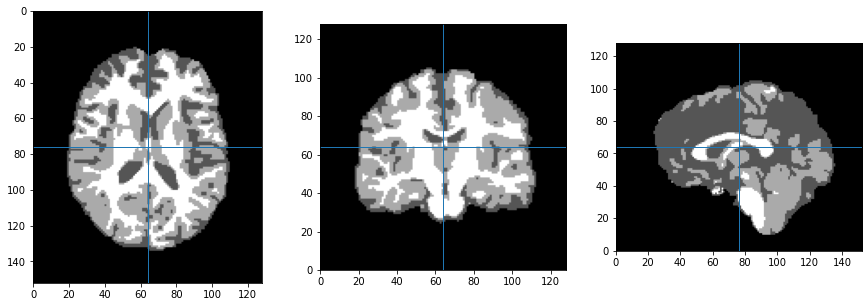

newmsub-CC310331_T1w_rigid_to_mni.nii.gz


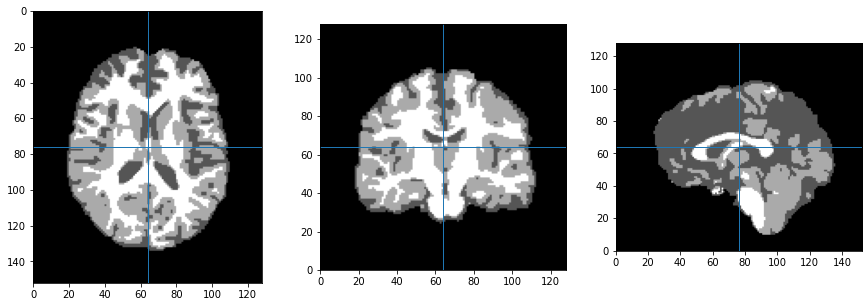

newmsub-CC420582_T1w_rigid_to_mni.nii.gz


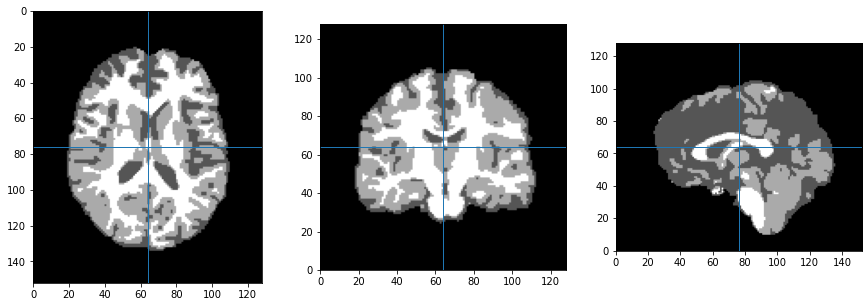

newmsub-CC620720_T1w_rigid_to_mni.nii.gz


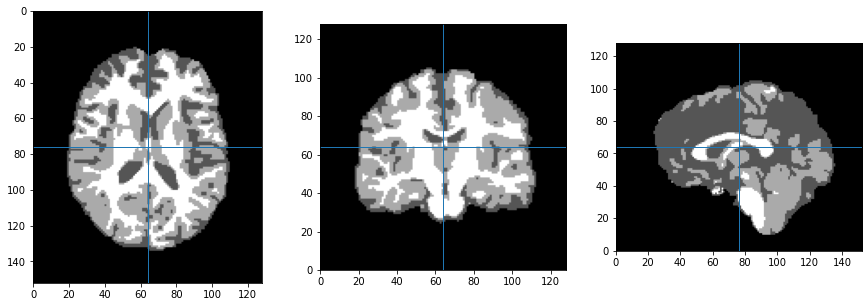

newmsub-CC121111_T1w_rigid_to_mni.nii.gz


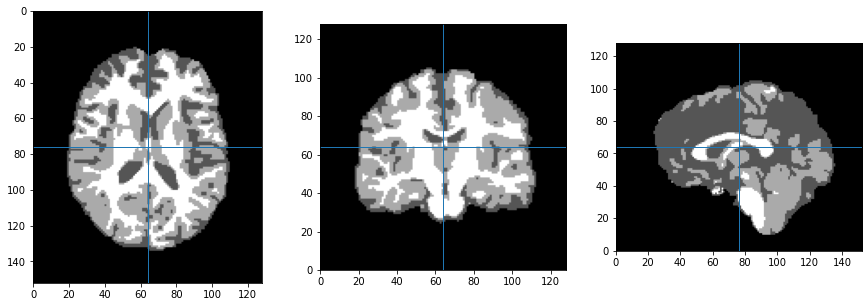

newmsub-CC510474_T1w_rigid_to_mni.nii.gz


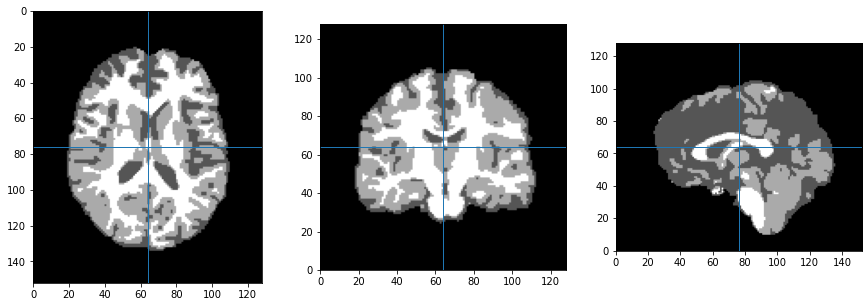

newmsub-CC720685_T1w_rigid_to_mni.nii.gz


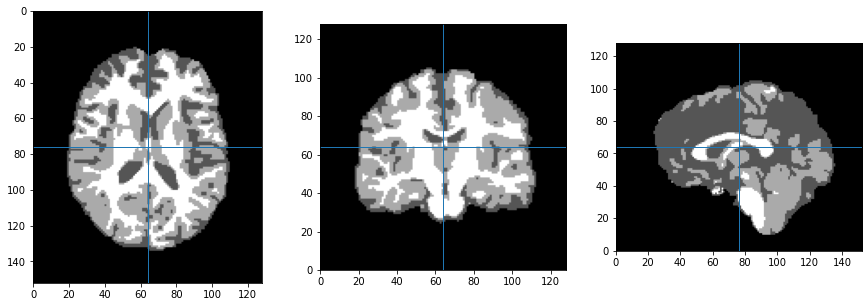

newmsub-CC510568_T1w_rigid_to_mni.nii.gz


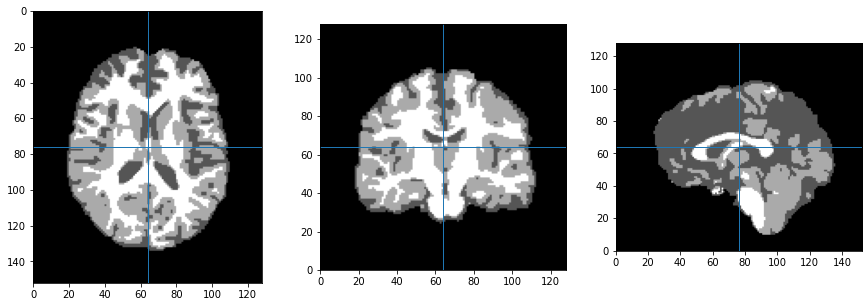

newmsub-CC721894_T1w_rigid_to_mni.nii.gz


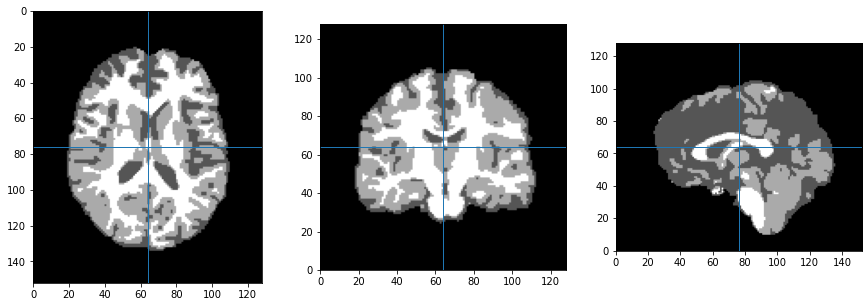

newmsub-CC310052_T1w_rigid_to_mni.nii.gz


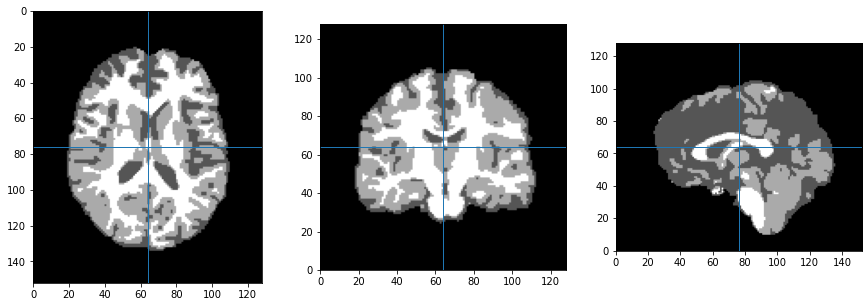

newmsub-CC320759_T1w_rigid_to_mni.nii.gz


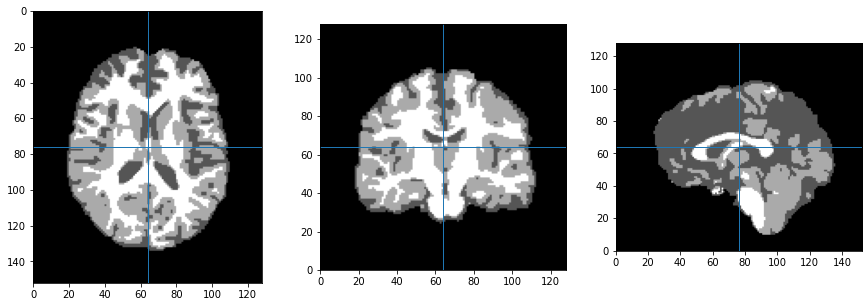

newmsub-CC210250_T1w_rigid_to_mni.nii.gz


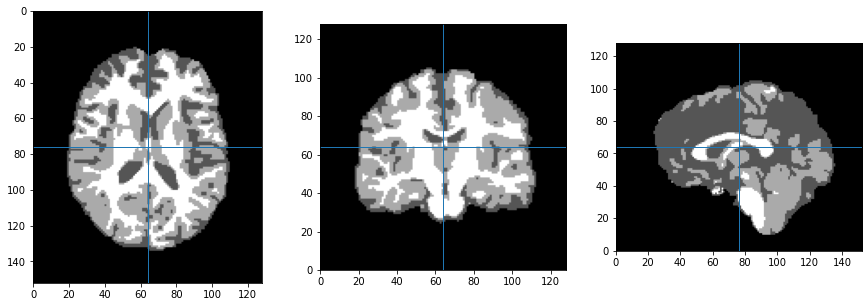

newmsub-CC220335_T1w_rigid_to_mni.nii.gz


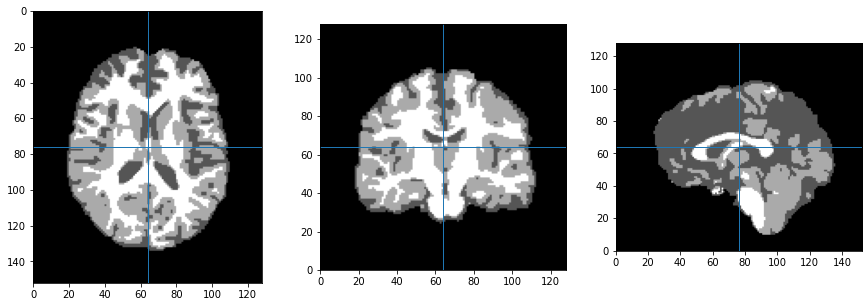

newmsub-CC610372_T1w_rigid_to_mni.nii.gz


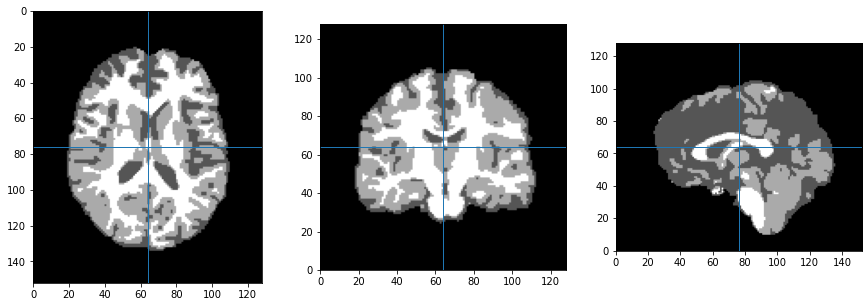

newmsub-CC720622_T1w_rigid_to_mni.nii.gz


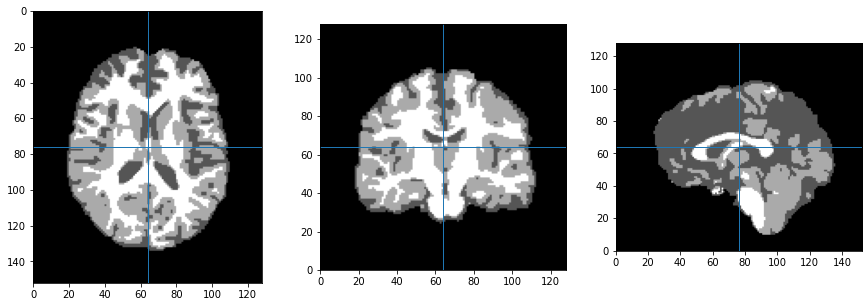

newmsub-CC121397_T1w_rigid_to_mni.nii.gz


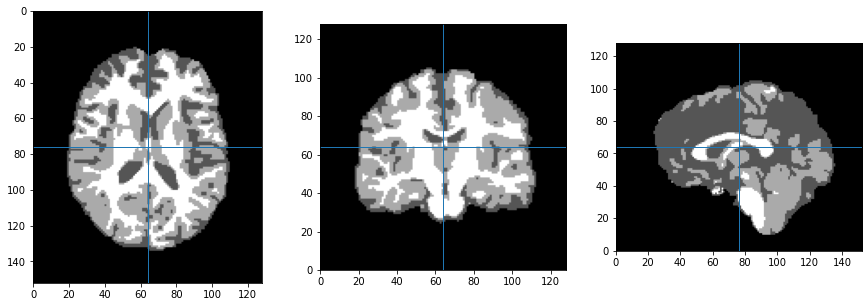

newmsub-CC321976_T1w_rigid_to_mni.nii.gz


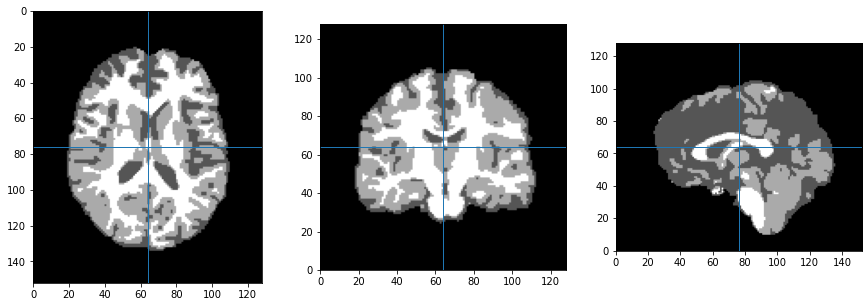

newmsub-CC410097_T1w_rigid_to_mni.nii.gz


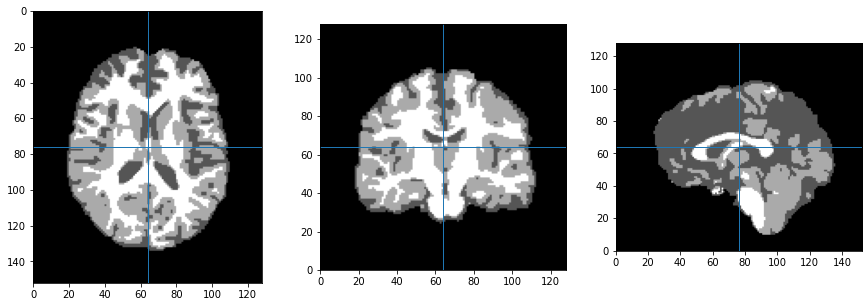

newmsub-CC510256_T1w_rigid_to_mni.nii.gz


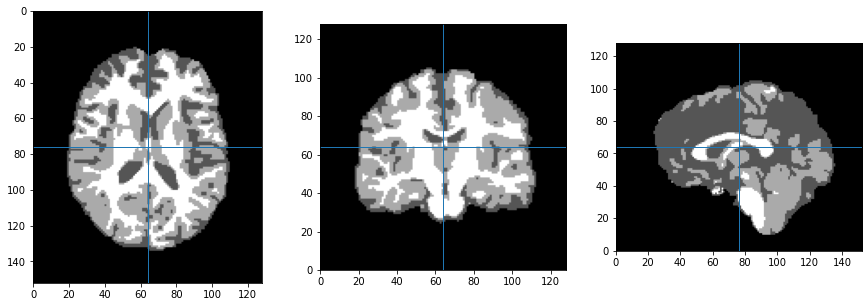

newmsub-CC610462_T1w_rigid_to_mni.nii.gz


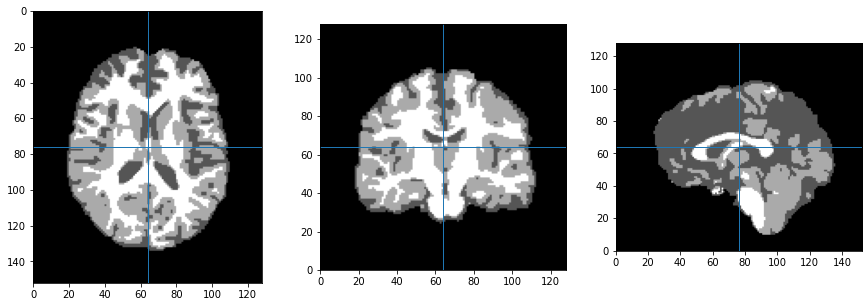

newmsub-CC121317_T1w_rigid_to_mni.nii.gz


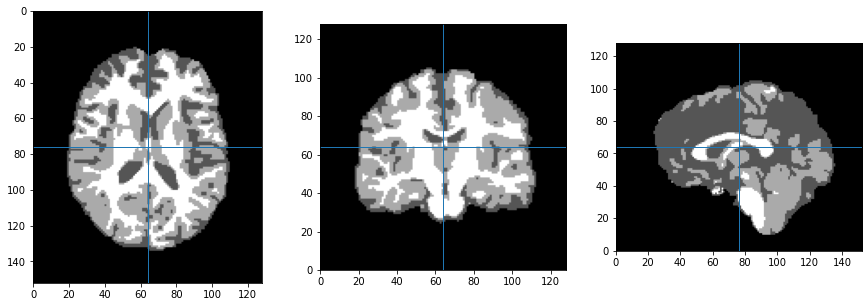

newmsub-CC320888_T1w_rigid_to_mni.nii.gz


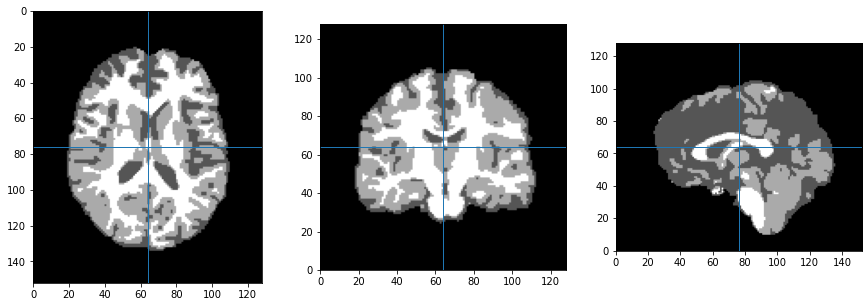

newmsub-CC410113_T1w_rigid_to_mni.nii.gz


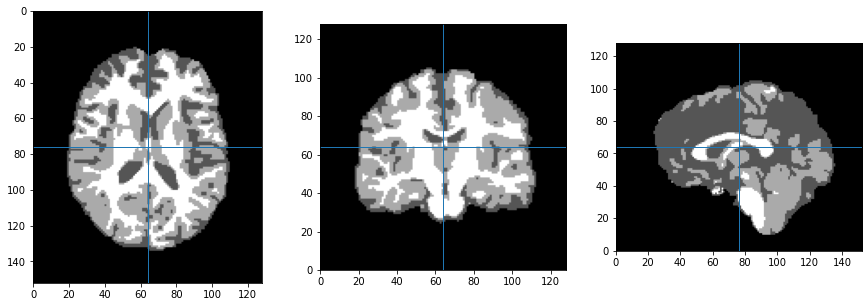

newmsub-CC520552_T1w_rigid_to_mni.nii.gz


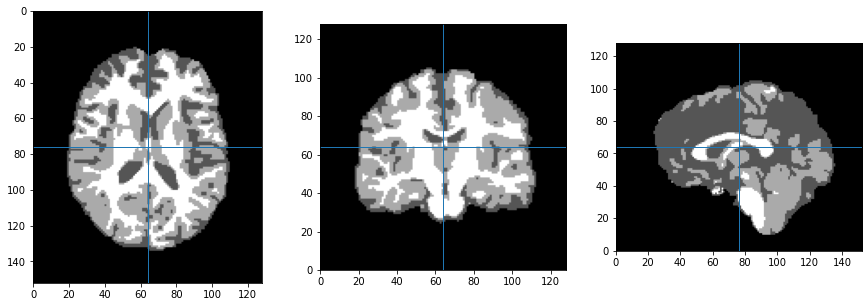

newmsub-CC720646_T1w_rigid_to_mni.nii.gz


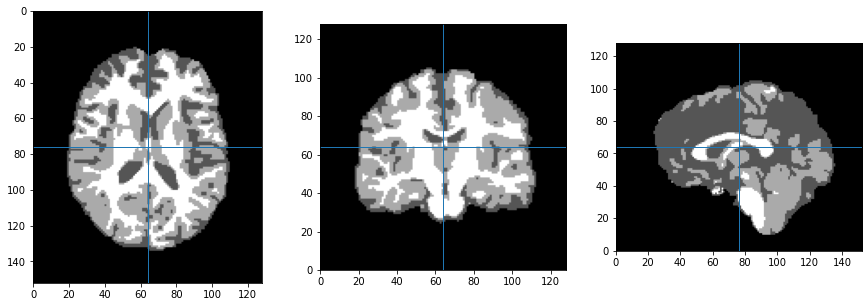

newmsub-CC320336_T1w_rigid_to_mni.nii.gz


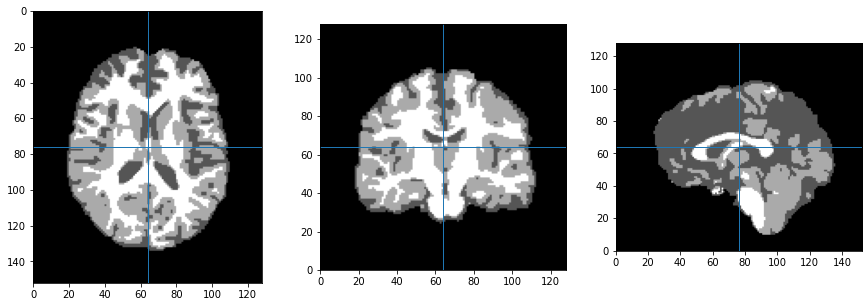

newmsub-CC510415_T1w_rigid_to_mni.nii.gz


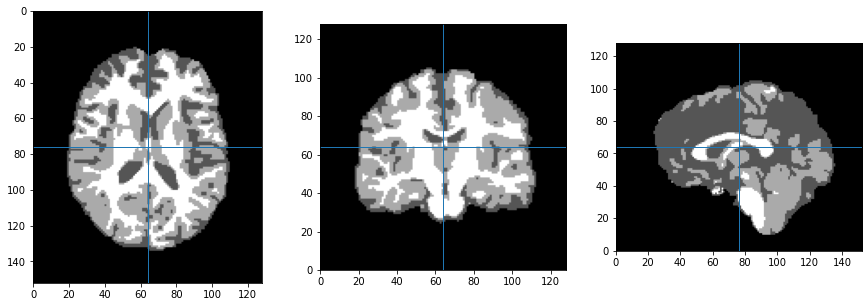

newmsub-CC120123_T1w_rigid_to_mni.nii.gz


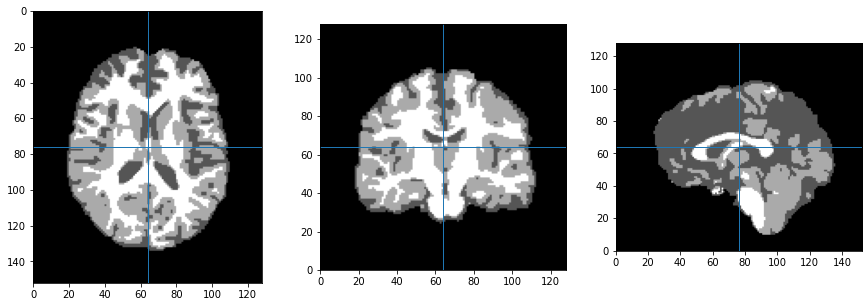

newmsub-CC221977_T1w_rigid_to_mni.nii.gz


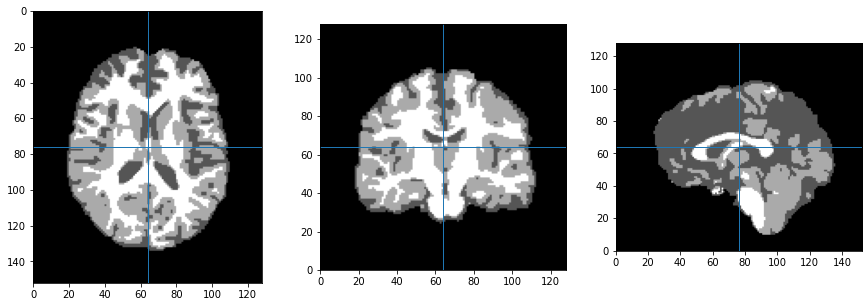

newmsub-CC121106_T1w_rigid_to_mni.nii.gz


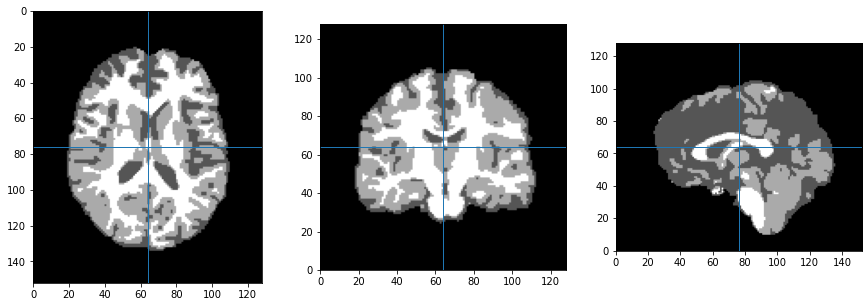

newmsub-CC310224_T1w_rigid_to_mni.nii.gz


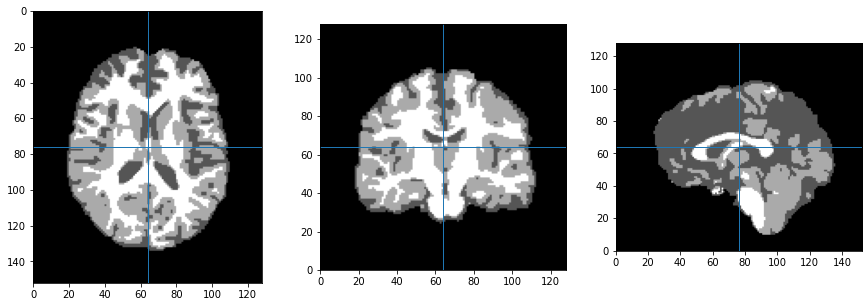

newmsub-CC520215_T1w_rigid_to_mni.nii.gz


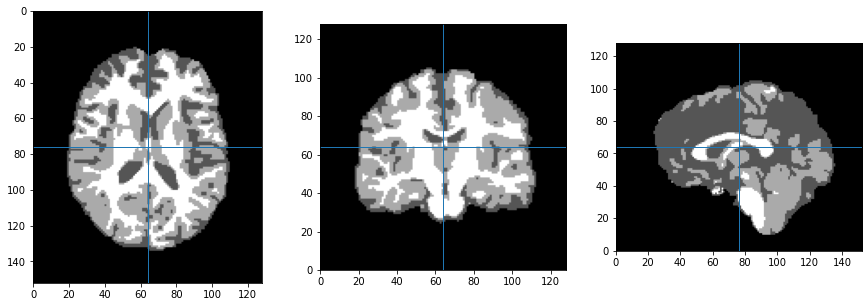

newmsub-CC420149_T1w_rigid_to_mni.nii.gz


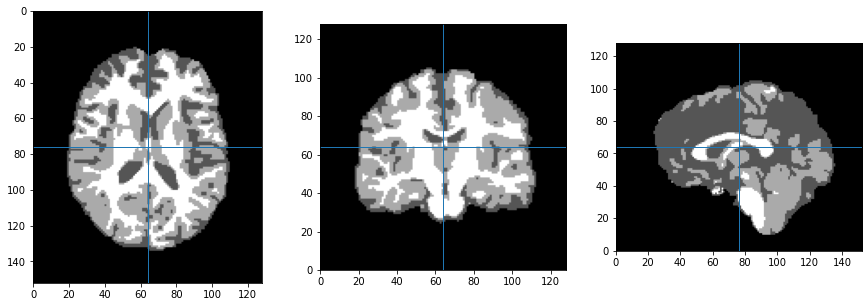

newmsub-CC620164_T1w_rigid_to_mni.nii.gz


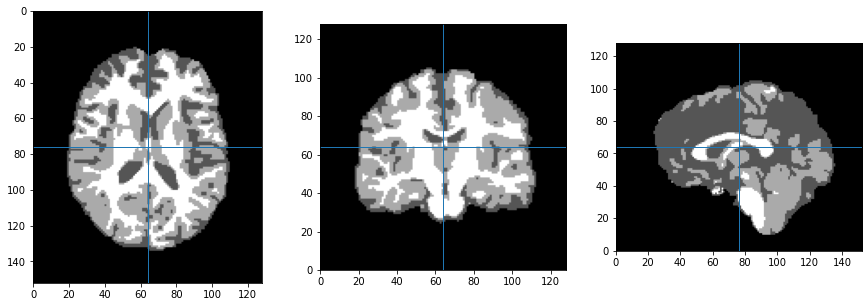

newmsub-CC320553_T1w_rigid_to_mni.nii.gz


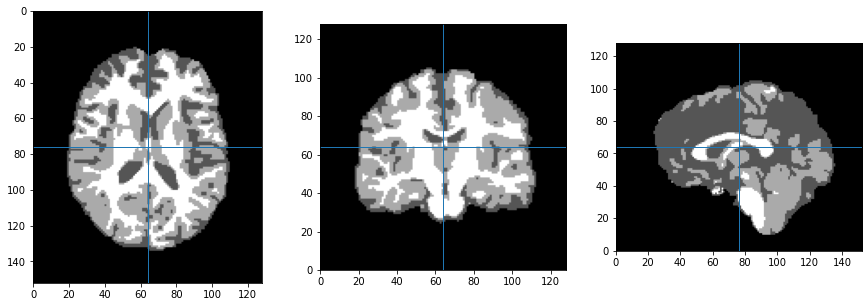

newmsub-CC520197_T1w_rigid_to_mni.nii.gz


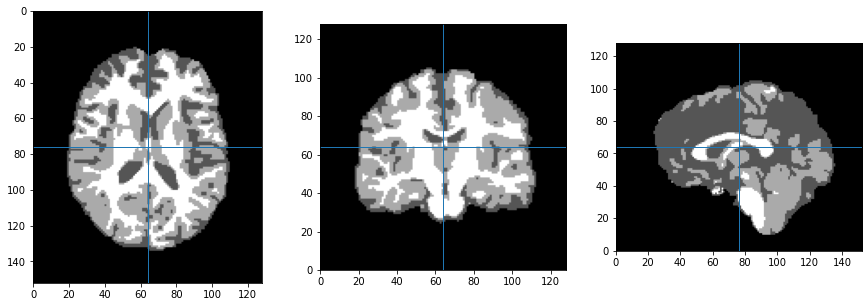

newmsub-CC310160_T1w_rigid_to_mni.nii.gz


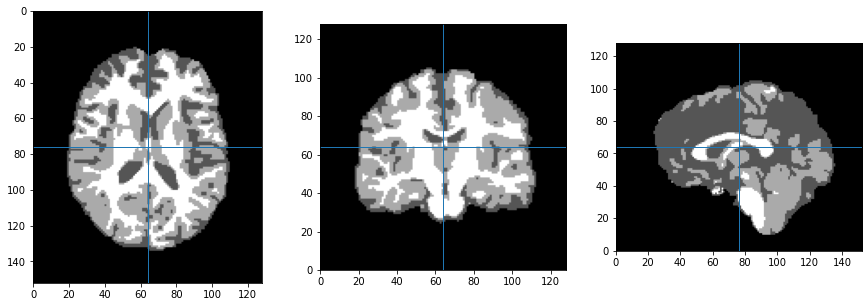

newmsub-CC320686_T1w_rigid_to_mni.nii.gz


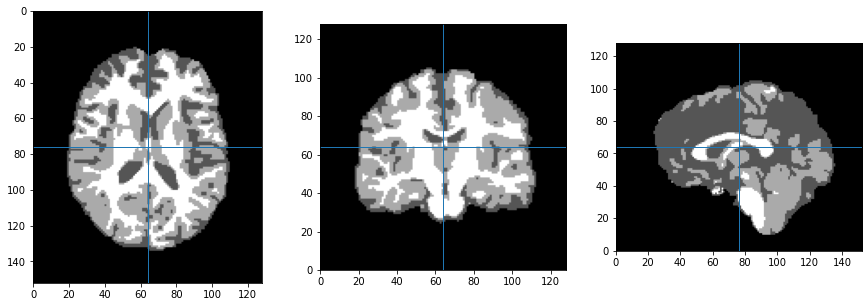

newmsub-CC222652_T1w_rigid_to_mni.nii.gz


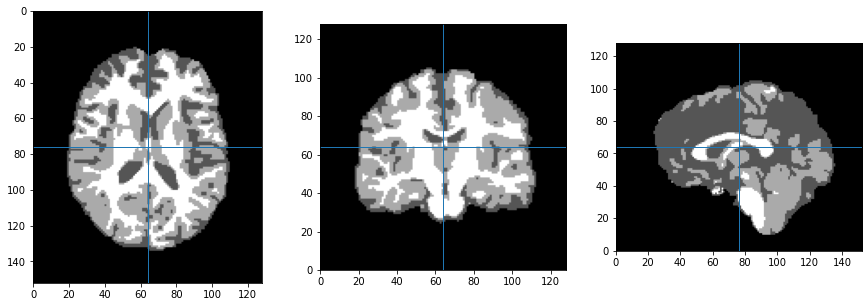

newmsub-CC710462_T1w_rigid_to_mni.nii.gz


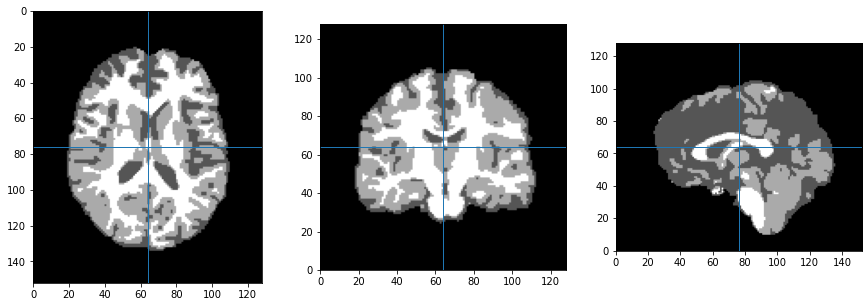

newmsub-CC721107_T1w_rigid_to_mni.nii.gz


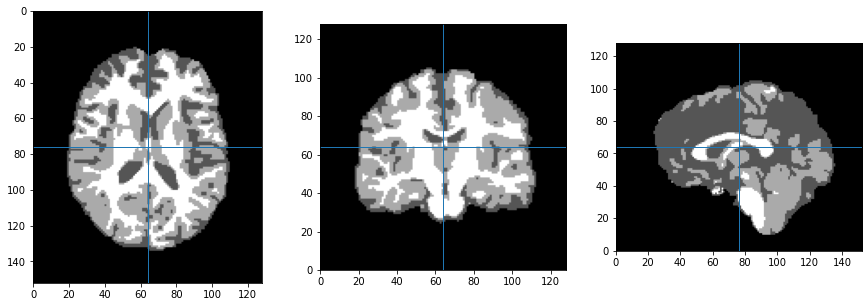

newmsub-CC510242_T1w_rigid_to_mni.nii.gz


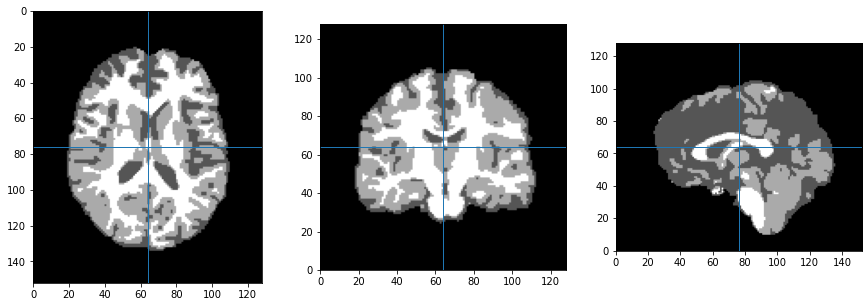

newmsub-CC620436_T1w_rigid_to_mni.nii.gz


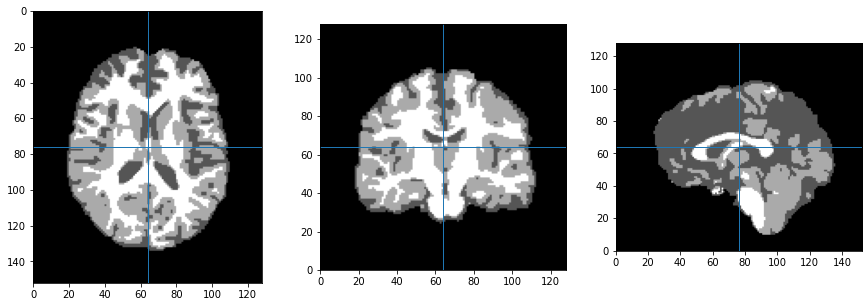

newmsub-CC320651_T1w_rigid_to_mni.nii.gz


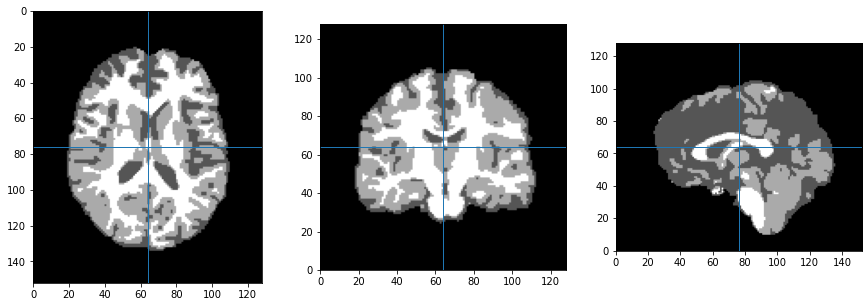

newmsub-CC721888_T1w_rigid_to_mni.nii.gz


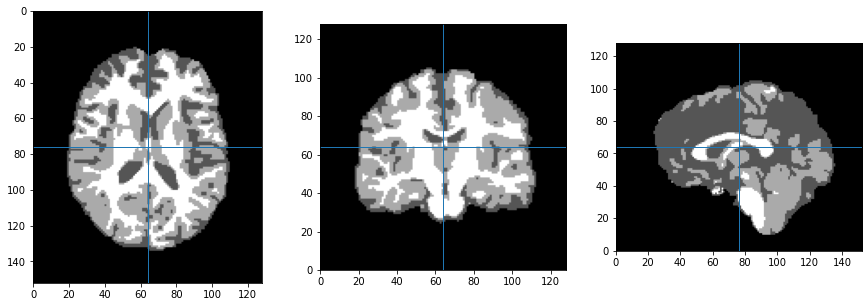

newmsub-CC310414_T1w_rigid_to_mni.nii.gz


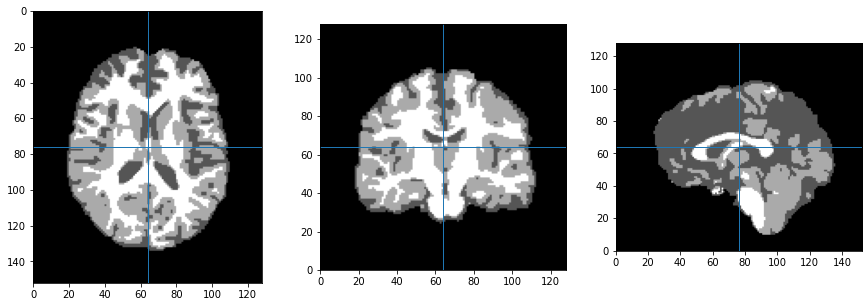

newmsub-CC520013_T1w_rigid_to_mni.nii.gz


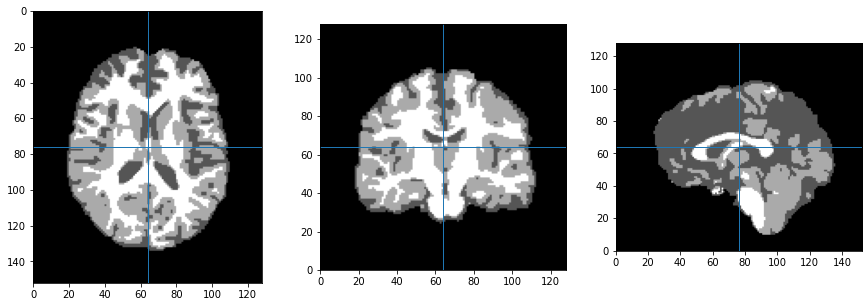

newmsub-CC223115_T1w_rigid_to_mni.nii.gz


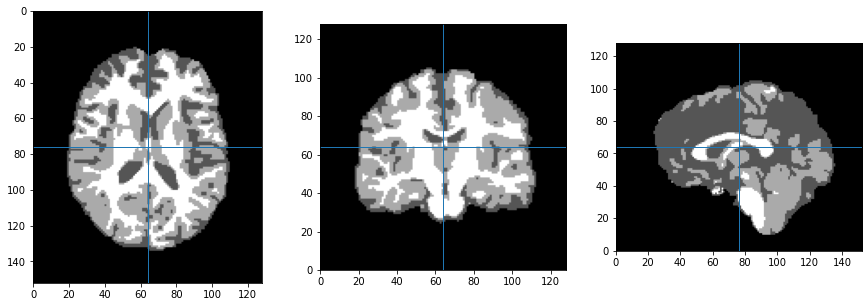

newmsub-CC420148_T1w_rigid_to_mni.nii.gz


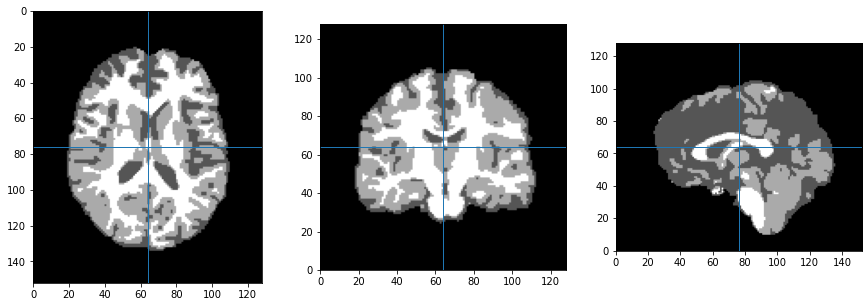

newmsub-CC420202_T1w_rigid_to_mni.nii.gz


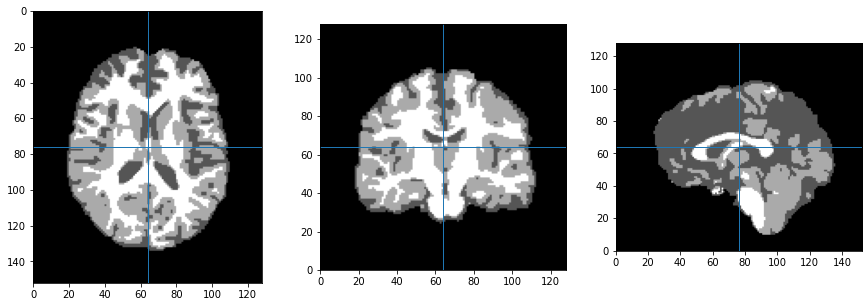

newmsub-CC711128_T1w_rigid_to_mni.nii.gz


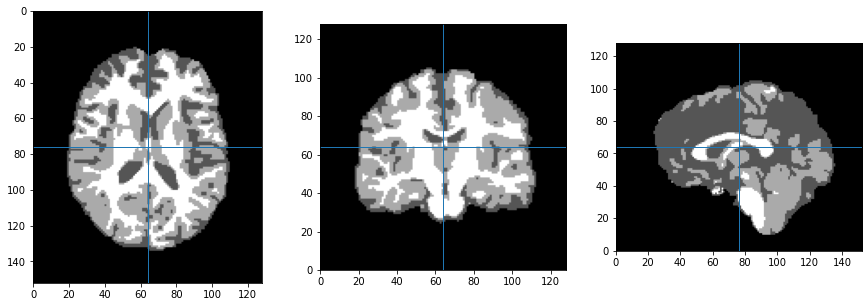

newmsub-CC221107_T1w_rigid_to_mni.nii.gz


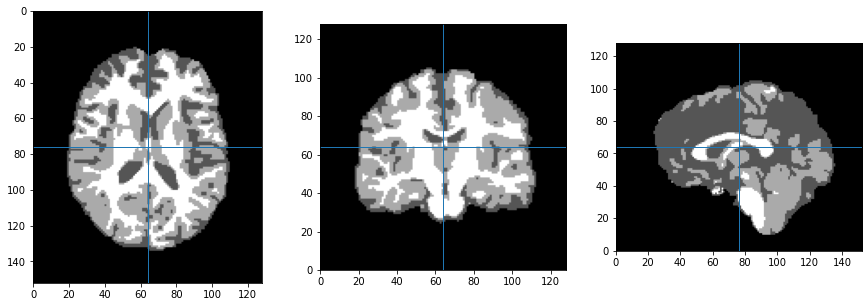

newmsub-CC210051_T1w_rigid_to_mni.nii.gz


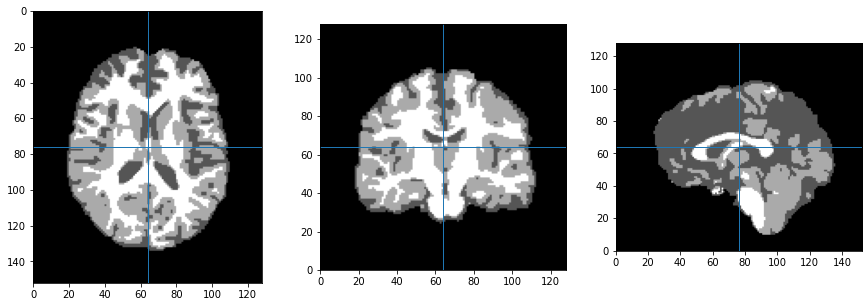

newmsub-CC420204_T1w_rigid_to_mni.nii.gz


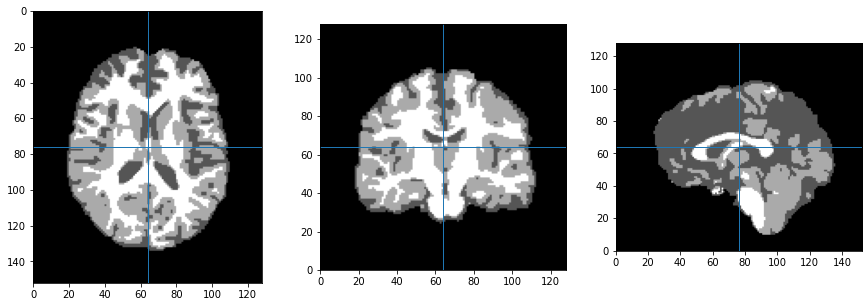

newmsub-CC710679_T1w_rigid_to_mni.nii.gz


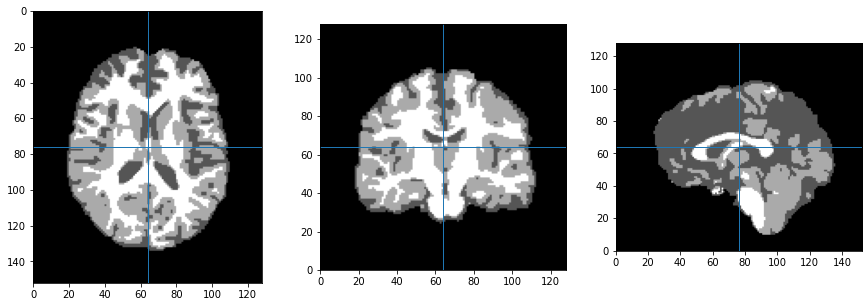

newmsub-CC520503_T1w_rigid_to_mni.nii.gz


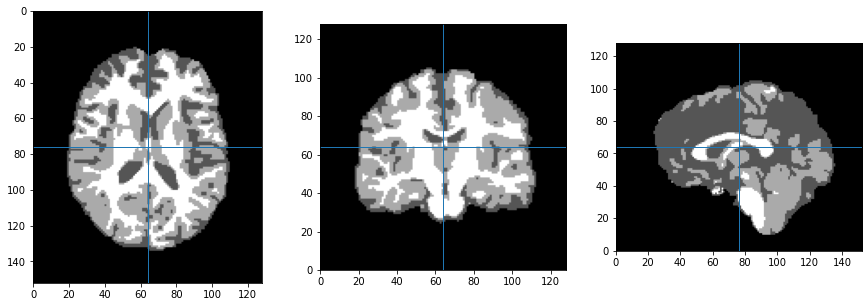

newmsub-CC510243_T1w_rigid_to_mni.nii.gz


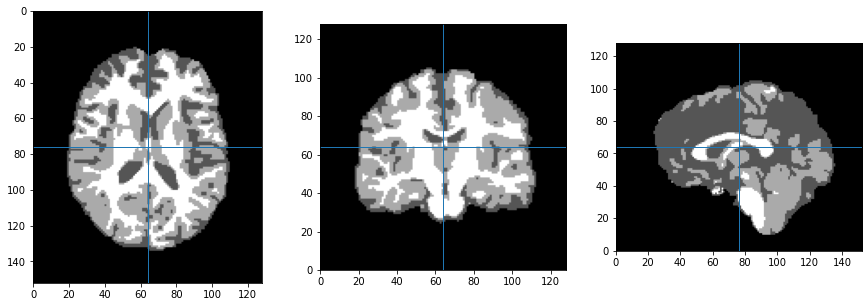

newmsub-CC710154_T1w_rigid_to_mni.nii.gz


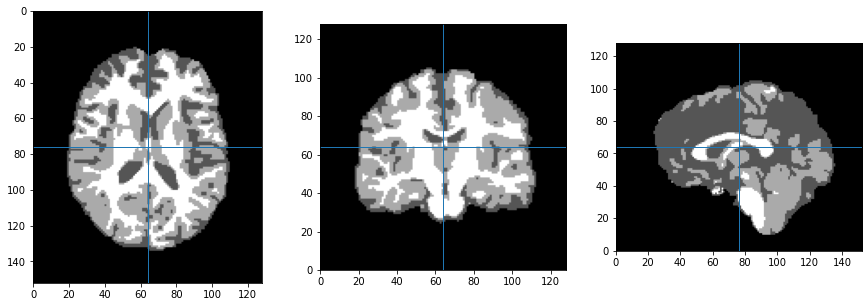

newmsub-CC420060_T1w_rigid_to_mni.nii.gz


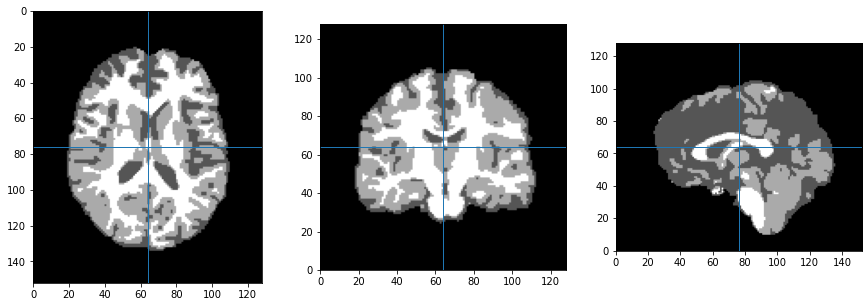

newmsub-CC620129_T1w_rigid_to_mni.nii.gz


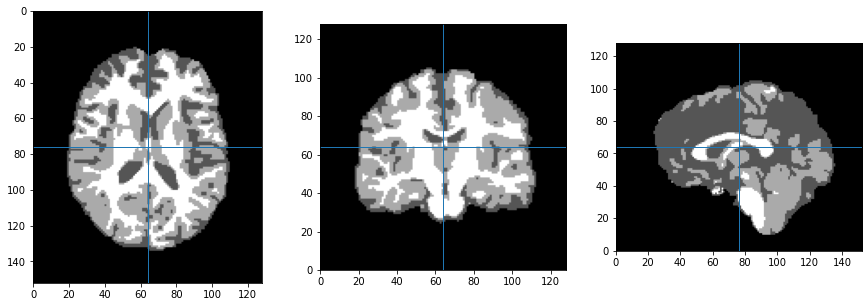

newmsub-CC620259_T1w_rigid_to_mni.nii.gz


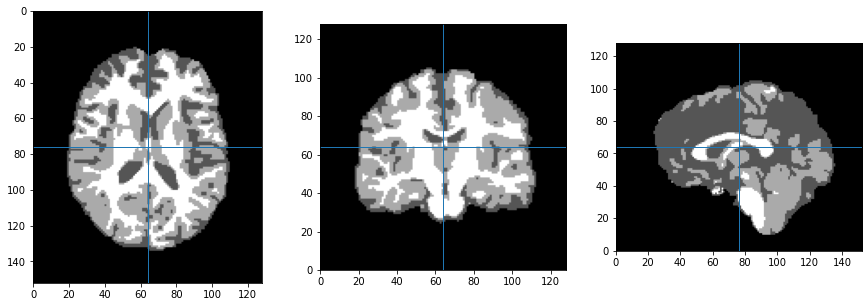

newmsub-CC510163_T1w_rigid_to_mni.nii.gz


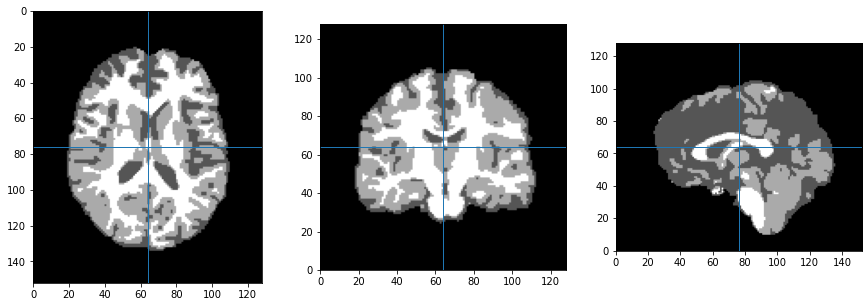

newmsub-CC110101_T1w_rigid_to_mni.nii.gz


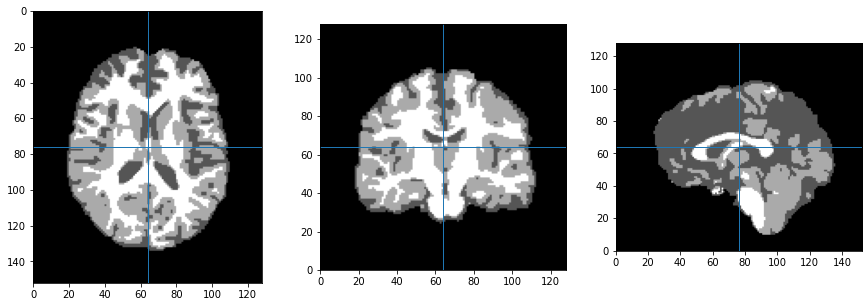

newmsub-CC721291_T1w_rigid_to_mni.nii.gz


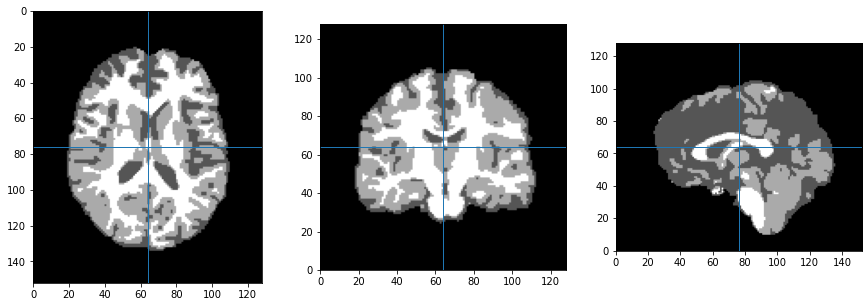

newmsub-CC120462_T1w_rigid_to_mni.nii.gz


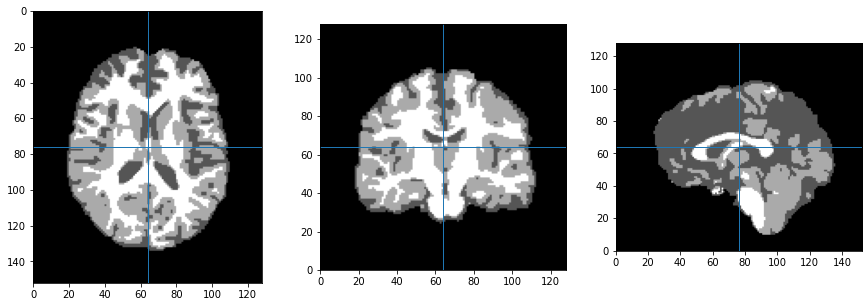

newmsub-CC321107_T1w_rigid_to_mni.nii.gz


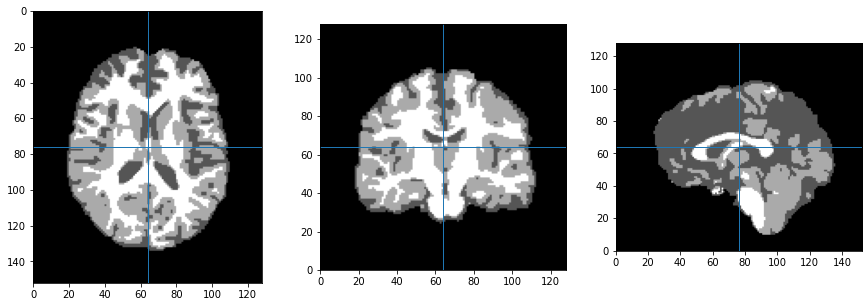

newmsub-CC721532_T1w_rigid_to_mni.nii.gz


KeyboardInterrupt: 

In [43]:
for i in new_image_filenames:
    print(i.split('/')[-1])
    new_name = i.split('/')[-1]
    save_dir = data_dir + 'new_images/'
    img_new = sitk.ReadImage(save_dir + name)
    #display_image(img_new)

In [30]:
print(len(image_filenames))

652


In [60]:
for i in range(len(image_filenames)):
    # Subject with index 0
    ID = meta_data['ID'][i]
    image_filename = [f for f in image_filenames if ID in f][0]
    img = sitk.ReadImage(image_filename)
    mask_filename = [f for f in mask_filenames if ID in f][0]
    msk = sitk.ReadImage(mask_filename)
    img_array = sitk.GetArrayFromImage(img)
    msk_array = sitk.GetArrayFromImage(msk)
    msk_array = msk_array.astype(bool)
    S = BrainT1Segmentation(img_array,
                        mask=msk_array,       
                        model='5k',
                        niters=int(50),  # number of iterations
                        beta=float(0.5), # Markov regularization parameter
                        ngb_size=int(6)) # neighborhood size of MRF
    img_S = sitk.GetImageFromArray(S.label)
    name = 'new' + image_filename.split('/')[-1]
    save_dir = data_dir + 'new_images/'
    save_path = os.path.join(save_dir,name)   #   get the save path
    sitk.WriteImage(img_S,save_path)
    shape_stats = sitk.LabelShapeStatisticsImageFilter()
    shape_stats.ComputeOrientedBoundingBoxOn()
    shape_stats.Execute(img_S)
    shape_labels = shape_stats.GetLabels()
    #print(image_filename.split('/')[-1])
    shape_volumes = [shape_stats.GetPhysicalSize(label) for label in shape_labels] 
    #print(shape_volumes)
    

msub-CC110033_T1w_rigid_to_mni.nii.gz
[101765.0, 210876.0, 107543.0]
msub-CC110037_T1w_rigid_to_mni.nii.gz
[95349.0, 216646.0, 110607.0]
msub-CC110045_T1w_rigid_to_mni.nii.gz
[88358.0, 231343.0, 96984.0]
msub-CC110056_T1w_rigid_to_mni.nii.gz
[74962.0, 209581.0, 97743.0]
msub-CC110062_T1w_rigid_to_mni.nii.gz
[123892.0, 225340.0, 125684.0]
msub-CC110069_T1w_rigid_to_mni.nii.gz
[89260.0, 217869.0, 109697.0]
msub-CC110087_T1w_rigid_to_mni.nii.gz
[86089.0, 204598.0, 92461.0]
msub-CC110098_T1w_rigid_to_mni.nii.gz
[104037.0, 234854.0, 110262.0]
msub-CC110101_T1w_rigid_to_mni.nii.gz
[122726.0, 236379.0, 116459.0]
msub-CC110126_T1w_rigid_to_mni.nii.gz
[95464.0, 231576.0, 112298.0]
msub-CC110174_T1w_rigid_to_mni.nii.gz
[68725.0, 188734.0, 82948.0]
msub-CC110182_T1w_rigid_to_mni.nii.gz
[85604.0, 214290.0, 95902.0]
msub-CC110187_T1w_rigid_to_mni.nii.gz
[81637.0, 219513.0, 99167.0]
msub-CC110319_T1w_rigid_to_mni.nii.gz
[108435.0, 231887.0, 123551.0]
msub-CC110411_T1w_rigid_to_mni.nii.gz
[133407.0, 

In [31]:
stats_list = [(shape_stats.GetPhysicalSize(i) for i in shape_stats.GetLabels())]
cols=["Volume 1 (nm^3)", "Volume 2", "Volume 3"]

# Create the pandas data frame and display descriptive statistics.
stats = pd.DataFrame(data=stats_list, index=shape_stats.GetLabels(), columns=cols)
stats.describe()

Volume 1 (nm^3)  Volume 2  Volume 3
count              3.0       3.0       3.0
mean          101765.0  210876.0  107543.0
std                0.0       0.0       0.0
min           101765.0  210876.0  107543.0
25%           101765.0  210876.0  107543.0
50%           101765.0  210876.0  107543.0
75%           101765.0  210876.0  107543.0
max           101765.0  210876.0  107543.0

In [32]:
IDs_list = []
volumes_list = []
for i in range(len(new_image_filenames)):
    # Subject with index 0
    ID = meta_data['ID'][i]
    image_filename = [f for f in new_image_filenames if ID in f][0]
    img = sitk.ReadImage(image_filename)
    shape_stats = sitk.LabelShapeStatisticsImageFilter()
    shape_stats.ComputeOrientedBoundingBoxOn()
    shape_stats.Execute(img)
    shape_labels = shape_stats.GetLabels()
    shape_volumes = [shape_stats.GetPhysicalSize(label) for label in shape_labels]
    #stats_list = [(shape_stats.GetPhysicalSize(i) for i in shape_stats.GetLabels())]
    volumes_list.append(shape_volumes)
    IDs_list.append(ID) 
    
#print(shape_volumes)
cols=["Volume 1 (nm^3)", "Volume 2", "Volume 3"]
# Create the pandas data frame and display volumes.
stats = pd.DataFrame(data=volumes_list, index = IDs_list, columns=cols)
#print(ID)
#print(volumes_list)



In [33]:
stats.head()

Volume 1 (nm^3)  Volume 2  Volume 3
CC110033         101765.0  210876.0  107543.0
CC110037          95349.0  216646.0  110607.0
CC110045          88358.0  231343.0   96984.0
CC110056          74962.0  209581.0   97743.0
CC110062         123892.0  225340.0  125684.0

### Feature calculation

A function that calculates volume features given the three tissue volumes and the overal brain volume (which is calculated from the brain masks) is implemented. A big matrix $X$ with a row for each subject and features across the columns is constructed.


In [34]:
total_volume_IDs_list = []
total_volumes_list = []
for i in range(len(mask_filenames)):
    # Subject with index 0
    ID = meta_data['ID'][i]
    mask_filename = [f for f in mask_filenames if ID in f][0]
    msk = sitk.ReadImage(mask_filename)
    shape_stats = sitk.LabelShapeStatisticsImageFilter()
    shape_stats.ComputeOrientedBoundingBoxOn()
    shape_stats.Execute(msk)
    shape_labels = shape_stats.GetLabels()
    shape_volumes = [shape_stats.GetPhysicalSize(label) for label in shape_labels]
    #stats_list = [(shape_stats.GetPhysicalSize(i) for i in shape_stats.GetLabels())]
    total_volumes_list.append(shape_volumes)
    total_volume_IDs_list.append(ID) 
    
#print(shape_volumes)
total_volume=["Total Volume"]
# Create the pandas data frame and display volumes.
total_volume_df = pd.DataFrame(data=total_volumes_list, index = total_volume_IDs_list, columns=total_volume)
#print(ID)
#print(volumes_list)



In [35]:
total_volume_df.shape

(652, 1)

In [36]:
total_volume_df.head()

Total Volume
CC110033   1418121.000
CC110037   1426281.750
CC110045   1406311.875
CC110056   1290215.250
CC110062   1602841.500

In [37]:
df_volumes = pd.concat([stats, total_volume_df], axis = 1)
df_volumes.shape

(652, 4)

In [38]:
df_volumes.head()

Volume 1 (nm^3)  Volume 2  Volume 3  Total Volume
CC110033         101765.0  210876.0  107543.0   1418121.000
CC110037          95349.0  216646.0  110607.0   1426281.750
CC110045          88358.0  231343.0   96984.0   1406311.875
CC110056          74962.0  209581.0   97743.0   1290215.250
CC110062         123892.0  225340.0  125684.0   1602841.500

In [39]:
relative_vols = ['Rel_vol1', 'Rel_vol2', 'Rel_vol3']
df_volume_features = pd.DataFrame(index = IDs_list, columns = relative_vols)
df_volume_features['Rel_vol1'] = df_volumes['Volume 1 (nm^3)'] / df_volumes['Total Volume']
df_volume_features['Rel_vol2'] = df_volumes['Volume 2'] / df_volumes['Total Volume']
df_volume_features['Rel_vol3'] = df_volumes['Volume 3'] / df_volumes['Total Volume']
df_volume_features.head()

Rel_vol1  Rel_vol2  Rel_vol3
CC110033  0.071760  0.148701  0.075835
CC110037  0.066851  0.151896  0.077549
CC110045  0.062830  0.164503  0.068963
CC110056  0.058100  0.162439  0.075757
CC110062  0.077295  0.140588  0.078413

In [40]:
volume_features = pd.concat([df_volumes, df_volume_features], axis = 1)
volume_features.shape

(652, 7)

In [41]:
volume_features.head()

Volume 1 (nm^3)  Volume 2  Volume 3  Total Volume  Rel_vol1  \
CC110033         101765.0  210876.0  107543.0   1418121.000  0.071760   
CC110037          95349.0  216646.0  110607.0   1426281.750  0.066851   
CC110045          88358.0  231343.0   96984.0   1406311.875  0.062830   
CC110056          74962.0  209581.0   97743.0   1290215.250  0.058100   
CC110062         123892.0  225340.0  125684.0   1602841.500  0.077295   

          Rel_vol2  Rel_vol3  
CC110033  0.148701  0.075835  
CC110037  0.151896  0.077549  
CC110045  0.164503  0.068963  
CC110056  0.162439  0.075757  
CC110062  0.140588  0.078413

In [42]:
volume_features.loc[['CC110033']]['Volume 2']

CC110033    210876.0
Name: Volume 2, dtype: float64

In [43]:
volume_features['Volume 2']

CC110033    210876.0
CC110037    216646.0
CC110045    231343.0
CC110056    209581.0
CC110062    225340.0
              ...   
CC722542    176539.0
CC722651    183691.0
CC722891    171714.0
CC723197    173059.0
CC723395    166310.0
Name: Volume 2, Length: 652, dtype: float64

In [46]:

def volume_feature_func(tissue_volumes, total_volume):
    rel_vols = [i/total_volume for i in tissue_volumes]
    return rel_vols
volumes_list = [df_volumes.loc[['CC110033']]['Volume 1 (nm^3)'],df_volumes.loc[['CC110033']]['Volume 2'],df_volumes.loc[['CC110033']]['Volume 3']]
relatives = volume_feature_func(volumes_list,df_volumes.loc[['CC110033']]['Total Volume'])
print(relatives)

[CC110033    0.07176
dtype: float64, CC110033    0.148701
dtype: float64, CC110033    0.075835
dtype: float64]


In [47]:
all_volumes_list = [df_volumes['Volume 1 (nm^3)'],df_volumes['Volume 2'],df_volumes['Volume 3']]
all_relatives = volume_feature_func(all_volumes_list,df_volumes['Total Volume'])
print(len(all_relatives))
#print(all_relatives[0])
#print(all_relatives[1])
#print(all_relatives[2])
df_volume_features['Rel_vol1'] = all_relatives[0]
df_volume_features['Rel_vol2'] = all_relatives[1]
df_volume_features['Rel_vol3'] = all_relatives[2]
df_volume_features.head()

3


Rel_vol1  Rel_vol2  Rel_vol3
CC110033  0.071760  0.148701  0.075835
CC110037  0.066851  0.151896  0.077549
CC110045  0.062830  0.164503  0.068963
CC110056  0.058100  0.162439  0.075757
CC110062  0.077295  0.140588  0.078413

### Age regression and cross-validation

Different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) is implemented. The output vectur $y$ containing the age for each of the subjects is constructed.

The methods are evaluated using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 652 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

*Hint:* This [scikit-learn example](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html#sphx-glr-auto-examples-plot-cv-predict-py) might be useful.

In [48]:
from sklearn.linear_model import LinearRegression

In [50]:
#X = df_volume_features
#y = meta_data['age']


In [49]:
X = volume_features
y = meta_data['age']

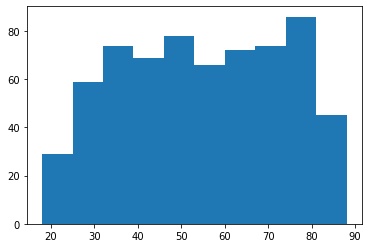

In [51]:
import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=10)

In [54]:
LinReg = LinearRegression()

In [55]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(326, 7) (326, 7) (326,) (326,)


In [56]:
LinReg.fit(X_train,y_train)

LinearRegression()

In [57]:
training_score = LinReg.score(X_train,y_train)
testing_score = LinReg.score(X_test, y_test)

In [58]:
print(training_score)
print(testing_score)

0.6042124513707676
0.5951673081551468


In [59]:
#pipeline
from sklearn.pipeline import Pipeline
#scalers from https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.neighbors import KNeighborsRegressor

In [60]:
#pipeline using StandardScaler()

pipe = Pipeline([
    ('scl', StandardScaler() ), # MinMaxScaler()
    ('lr', LinearRegression())
])

pipe.fit(X_train, y_train)

print('Test accuracy of testing pipe1: %.4f' % pipe.score(X_test,y_test))
print('Test accuracy of training pipe1: %.4f' % pipe.score(X_train,y_train))

Test accuracy of testing pipe1: 0.5968
Test accuracy of training pipe1: 0.6113


In [63]:
#I wanna do pipelines of various scalers
#Create the pipeline
#Three scalers in a pipeline

#MLR
pipe1 = Pipeline([
    ('scl', StandardScaler()),
    ('lr', LinearRegression())
])

pipe2 = Pipeline([
    ('mms', MinMaxScaler()),
    ('lr', LinearRegression())
])

pipe3 = Pipeline([
    ('rs', RobustScaler()),
    ('lr', LinearRegression())
])

pipe4 = Pipeline([
    ('norm', Normalizer()),
    ('lr', LinearRegression())
])

pipe5 = Pipeline([
    ('pow', PowerTransformer()),
    ('lr', LinearRegression())
])

pipe6 = Pipeline([
    ('qt', QuantileTransformer()),
    ('lr', LinearRegression())
])

pipe7 = Pipeline([
    ('scl', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

#Dict
pipe_line_dict = {0: 'StandardScaler', 
                  1: 'MinMaxScaler', 
                  2: 'RobustScaler',
                 3: 'Normalizer',
                 4: 'PowerTransformer',
                 5: 'QuantileTransformer',
                 6: 'KNN with StandardScaler'}

#PipeLine list for iteration 
pipelineList =[pipe1, pipe2, pipe3, pipe4, pipe5, pipe6, pipe7]

#Have data sets ready!
for pipe in pipelineList:
    pipe.fit(X_train,y_train)

#Find the best model in pipeline
for idx, val in enumerate(pipelineList):
    print('%s Pipeline test accuracy: %.4f' % 
          (pipe_line_dict[idx], val.score(X_test,y_test))
         )
    print('%s Pipeline train accuracy: %.4f' % 
          (pipe_line_dict[idx], val.score(X_train,y_train))
         )

StandardScaler Pipeline test accuracy: 0.5968
StandardScaler Pipeline train accuracy: 0.6113
MinMaxScaler Pipeline test accuracy: 0.5757
MinMaxScaler Pipeline train accuracy: 0.6043
RobustScaler Pipeline test accuracy: 0.5982
RobustScaler Pipeline train accuracy: 0.6119
Normalizer Pipeline test accuracy: 0.4747
Normalizer Pipeline train accuracy: 0.6137
PowerTransformer Pipeline test accuracy: 0.6176
PowerTransformer Pipeline train accuracy: 0.6353
QuantileTransformer Pipeline test accuracy: 0.6299
QuantileTransformer Pipeline train accuracy: 0.6361
KNN with StandardScaler Pipeline test accuracy: 0.6243
KNN with StandardScaler Pipeline train accuracy: 0.7157


Text(0, 0.5, 'accuracy')

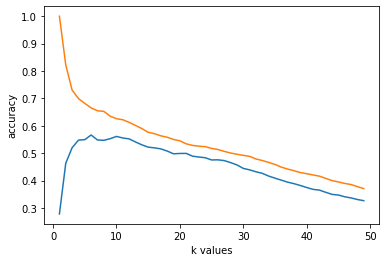

In [62]:

score_list_test = []
score_list_train = []
for each in range(1,50):
    knn2 = KNeighborsRegressor(n_neighbors= each)
    knn2.fit(X_train, y_train)
    score_list_test.append(knn2.score(X_test,y_test))
    score_list_train.append(knn2.score(X_train,y_train))
plt.plot(range(1, 50), score_list_test)
plt.plot(range(1, 50), score_list_train)
plt.xlabel("k values")
plt.ylabel("accuracy")  

#### Random Forest Importance

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
model = RandomForestRegressor(n_estimators=10, random_state=42)

In [66]:
# fit the regressor to the training set
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [67]:
# view the feature scores
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

Rel_vol1           0.530083
Volume 2           0.139626
Rel_vol2           0.112474
Rel_vol3           0.103571
Volume 3           0.041494
Volume 1 (nm^3)    0.038977
Total Volume       0.033775
dtype: float64

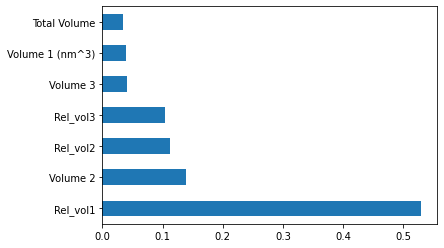

In [68]:
feature_scores.nlargest(10).plot(kind='barh')
plt.show()

In [69]:
from sklearn.feature_selection import SelectFromModel

In [71]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.05
sfm = SelectFromModel(model, threshold=0.05)

In [72]:
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=10,
                                                random_state=42),
                threshold=0.05)

In [73]:
feat_labels = X_train.columns

In [74]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Volume 2
Rel_vol1
Rel_vol2
Rel_vol3


###  k-fold 

In [75]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [77]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(326, 7) (326, 7) (326,) (326,)


In [83]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

In [90]:
r2 = []
for k in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred = cross_val_predict(knn, X_train, y_train, cv=2)
    r2.append(r2_score(y_train,y_pred)) # we can write r2 score. and choose highes

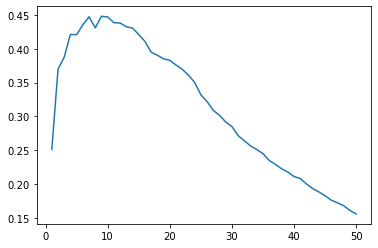

In [91]:
plt.plot(range(1,51),r2)

In [92]:
r2 = []
for k in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred = cross_val_predict(knn, X_test, y_test, cv=2)
    r2.append(r2_score(y_test,y_pred)) # we can write r2 score. and choose highes

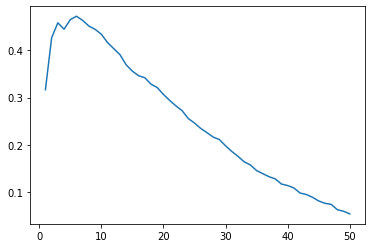

In [93]:
plt.plot(range(1,51),r2)

In [95]:
from sklearn.svm import LinearSVR

In [99]:
print(X.shape, y.shape)

(652, 7) (652,)


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [120]:
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X_train, y_train)

LinearSVR(epsilon=1.5, random_state=42)

In [124]:
svm_reg.score(X_train, y_train)

-0.28967952425244015

In [125]:
svm_reg.score(X_test, y_test)

-0.376349392794016

In [126]:
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X_train, y_train)

SVR(C=100, degree=2, kernel='poly')

In [127]:
svm_poly_reg.score(X_train, y_train)

0.4483482214231228

In [128]:
svm_poly_reg.score(X_test, y_test)

0.4957507230017395

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

LinearSVR(random_state=42)

In [122]:
lin_svr.score(X_train_scaled, y_train)

0.5231178858129448

In [123]:
lin_svr.score(X_test_scaled, y_test)

0.6376031887397453

In [103]:
y_pred = lin_svr.predict(X_train_scaled)
mse_training = mean_squared_error(y_train, y_pred)
mse_training

161.64679751739052

In [104]:
# RMSE:
np.sqrt(mse_training)

12.714039386339438

In [109]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=2, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=   0.0s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=   0.0s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=   0.0s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=   0.0s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   0.0s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=   0.0s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=   0.0s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=   0.0s
[CV] END ....C=7.011150117432088, gamma=0.026070247583707663; total time=   0.0s
[CV] END ....C=7.011150117432088, gamma=0.026070247583707663; total time=   0.0s
[CV] END .....C=1.2058449429580245, gamma=0.0870602087830485; total time=   0.0s
[CV] END .....C=1.2058449429580245, gamma=0.0870

RandomizedSearchCV(cv=2, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7acbeb1790>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7acce761c0>},
                   random_state=42, verbose=2)

In [115]:
rnd_search_cv.best_estimator_

SVR(C=7.011150117432088, gamma=0.026070247583707663)

In [116]:
#measure the RMSE on the training set:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse_training = mean_squared_error(y_train, y_pred)
np.sqrt(mse_training)

11.177325228939262

In [117]:
#evaluate it on the test set:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse_testing = mean_squared_error(y_test, y_pred)
np.sqrt(mse_testing)

10.769478547613353

In [ ]:
svr = rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

In [118]:
svr.score(X_test_scaled,y_test)

0.6669747497597509

In [119]:
svr.score(X_train_scaled,y_train)

0.6314302356283137

In [133]:
from sklearn.tree import DecisionTreeRegressor


In [140]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [141]:
tree_reg1.score(X_train, y_train)

0.5816635155468892

In [142]:
tree_reg1.score(X_test, y_test)

0.5564863967320546

In [143]:
tree_reg1.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [144]:
tree_reg1.score(X_train_scaled, y_train)

0.5816635155468892

In [145]:
tree_reg1.score(X_test_scaled, y_test)

0.5564863967320546

In [146]:
from sklearn.ensemble import GradientBoostingRegressor

In [147]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [148]:
gbrt.score(X_train, y_train)

0.6869104744595904

In [149]:
gbrt.score(X_test, y_test)

0.6375101613930342

In [152]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=49, random_state=42)

In [154]:
gbrt_best.score(X_train,y_train)

0.7665320076513404

In [155]:
gbrt_best.score(X_test,y_test)

0.6655292636249763

**Gradient Boosting with Early stopping**

In [164]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping


In [165]:
print(gbrt.n_estimators)

44


In [166]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 117.47261376021889


In [167]:
from xgboost import XGBRegressor

In [168]:
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
val_error = mean_squared_error(y_test, y_pred) # Not shown
print("Validation MSE:", val_error)          

Validation MSE: 149.5108671559076


In [169]:
xgb_reg.score(X_train,y_train)

0.9999833506602946

In [170]:
xgb_reg.score(X_test, y_test)

0.5707003121584934